In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall() 

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
MaxDate = engine.execute("SELECT MAX(date) FROM Measurement").fetchall()
MaxDate[0][0]


'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
          filter(Measurement.date >= year_ago).all()

In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_ago_results = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
                     filter(Measurement.date == year_ago).all()
year_ago_results

[('2016-08-23', 0.0, 81.0),
 ('2016-08-23', 0.15, 76.0),
 ('2016-08-23', 0.05, 80.0),
 ('2016-08-23', None, 80.0),
 ('2016-08-23', 0.02, 80.0),
 ('2016-08-23', 1.79, 77.0),
 ('2016-08-23', 0.7, 74.0)]

In [14]:
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
date_prcp = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= year_ago).order_by(Measurement.date).all()
    

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(date_prcp).rename(columns={"date":"Date","prcp":"Precipitation"})
df.set_index("Date", inplace=True)
df.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


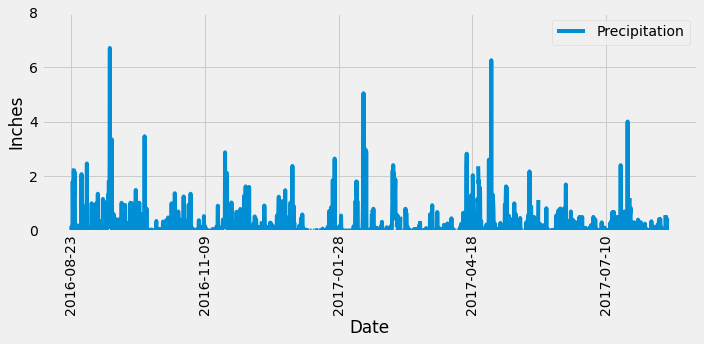

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize = (10,5), ylim=(0,8), label="Precipitation", rot=90)
plt.legend(loc='upper right')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
              group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                             filter(Measurement.station == 'USC00519281').all()

for temp in station_temp:
    print(f"The lowest temperature : {round(temp[0],2)}")
    print(f"The highest temperature : {round(temp[1],2)}")
    print(f"The average temperature : {round(temp[2],2)}")

The lowest temperature : 54.0
The highest temperature : 85.0
The average temperature : 71.66


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hist_data = session.query(Measurement.station, Measurement.tobs).\
                        filter(Measurement.station == 'USC00519281').\
                        filter(Measurement.date >= year_ago).all()
hist_df = pd.DataFrame(hist_data)
hist_df.set_index("station", inplace=True)
hist_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


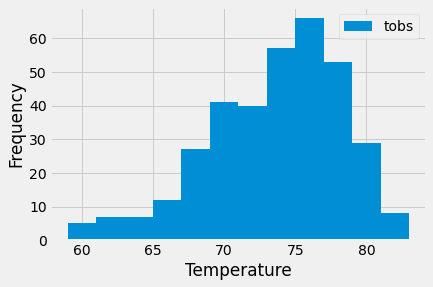

In [21]:
hist_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()